## 4. 통계학습의 성능개선

지금까지 통계학습모델들을 공부하고 실습 데이터를 활용하여 모델들을 구축해보았습니다. 하지만 일부 모델들은 과대적합과 과소적합등의 문제들로 생각보다 좋지 않은 성능을 보인다는 것을 알 수가 있었습니다. 해당 장을 통하여 이전에 결과가 좋지 않은 모델들의 성능을 개선시키는 방법에 대하여 배워보겠습니다.

기존의 선형회귀모델에서 데이터셋의 특성이 많아지고 과대적합 문제가 발생합니다. 과대적합이란 모델이 데이터의 특성을 과도하게 적합하게 되어 훈련되어진 데이터 이외의 데이터에는 제대로된 성능을 내지 못하는 문제를 말합니다. 과대 적합 문제를 해결하는 방법으로는

1. 특성의 갯수를 줄이기
 - 의미있는 특성만 선택하고 나머지는 버림
 - 변수선택법 알고리즘을 사용함
 - ex) 최상의 부분집합 선택법, 전진선택법
2. 규제화(Regularization)을 수행
 - 모튼 특성들을 사용하되 상수항을 제외한 모든 계수 추정치를 수축, 규제시킴
 - ex) 능형회귀(Ridge regression), 라쏘회귀(Lasso regression)  

과대적합과 반대로 과소적합 문제가 발생하게 되면 모델이 데이터를 제대로 학습하지 못하여 발생하는 오차가 커지고 이에 따라 예측값의 분산이 커지게 됩니다. 위의 방법을 통하여 분산을 제어할 수 있지만 대부분의 설명변수를 고려해야 합니다. 이러한 문제를 해결하는 방법으로는 아래와 같은 방법이 있습니다.

3. 차원 축소 방법
 - 설명변수들을 변환한 다음에 변환된 변수를 사용하여 모델 적합
 - ex) 주성분(principal components), 부분최소제곱(partial least squares)

In [156]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import itertools
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge, Lasso
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

### 4.1 변수선택법

데이터의 특성에 따라서 변수선택법을 해야되는 상황이 있습니다.
1. 데이터의 개수보다 변수의 개수가 더 많은 경우
 - 변수가 더 많은 데이터에 회귀모델을 적합하게 되면 분산이 크기 때문에 과적합이 발생하여 좋은 모델을 얻을 수 없습니다.

2. 데이터 프레임의 크기가 너무 커서 변수또한 프로그램을 돌리기에 시간이 오래 걸리는 경우
 - 분석하는 목적과 부합하지 않은 변수를 제거함으로써 계산상의 이득을 취할 수 있습니다.
 
3. 모델에 들어갈 독립변수간에 관련성, 상관성이 높은 경우  
 - 독립변수간에 상관성이 높은 경우 다중공선성의 문제가 발생합니다. 
 - 다중공선성 문제가 발생하면 회귀모델의 계수 추정치의 분산이 커져서 신뢰성있는 계수를 추정하기 어려워집니다.

일반적으로 데이터의 개수가 변수의 개수보다 많은 데이터 프레임들이 많지만 오히려 변수의 개수가 더 많은 경우도 빈번히 존재합니다.  
데이터 프레임 자체의 크기가 크거나 변수의 개수가 데이터 개수보다 많은 경우 의미가 있는 몇개의 변수만을 선택하여 분석하는 것이 합리적입니다.  
변수를 선택하기 위한 척도로는 대표적으로 RSS와 R_squared가 있으며 해당 책에서는 C_p, BIC, AIC, Adj.R_squared도 다루어 보겠습니다.

#### 4.1.1 최상의 부분집합 선택법

해당 데이터는 400명의 신용카드 사용자 데이터로 10개의 설명변수를 사용하여 반응변수인 income을 예측하는 회귀모델을 만듭니다. 이때 회귀모델이 어떠한 설명 변수를 사용하였을 경우가 최적의 모델이 만들어지는지 $RSS$와 결정계수 $R^2$를 통하여 판단하겠습니다.

여기서 $RSS$는 잔차제곱합이라고 부르며 해당 값이 작아질 수록 모델의 성능의 좋다고 볼수가 있습니다. 결정계수의 경우 클수록 모델의 성능이 좋다고 판단하는 척도로써 사용이 됩니다. 

In [3]:
data = pd.read_csv("./data/Credit.csv",index_col=[0])
print("데이터 개수 : {} \n변수 개수 : {}".format(data.shape[0],data.shape[1]))
data.head()

데이터 개수 : 400 
변수 개수 : 11


,Income,Limit,Rating,Cards,Age,Education,Gender,Student,Married,Ethnicity,Balance
1,14.891,3606,283,2,34,11,Male,No,Yes,Caucasian,333
2,106.025,6645,483,3,82,15,Female,Yes,Yes,Asian,903
3,104.593,7075,514,4,71,11,Male,No,No,Asian,580
4,148.924,9504,681,3,36,11,Female,No,No,Asian,964
5,55.882,4897,357,2,68,16,Male,No,Yes,Caucasian,331


데이터의 자료형과 결측값, 데이터 개수를 알아보겠습니다.

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 400 entries, 1 to 400
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Income     400 non-null    float64
 1   Limit      400 non-null    int64  
 2   Rating     400 non-null    int64  
 3   Cards      400 non-null    int64  
 4   Age        400 non-null    int64  
 5   Education  400 non-null    int64  
 6   Gender     400 non-null    object 
 7   Student    400 non-null    object 
 8   Married    400 non-null    object 
 9   Ethnicity  400 non-null    object 
 10  Balance    400 non-null    int64  
dtypes: float64(1), int64(6), object(4)
memory usage: 37.5+ KB


설명변수로 사용될 변수중에 범주형 변수가 존재하면 이를 모델이 분석가능한 형태로 만들어 주어야 하는데, 사용되는 방법중에 one-hot-encoding이 있습니다. one-hot-encoding이란 Gender 변수와 같이 2개의 범주 Male, Female로 구성된 데이터가 있을 때, 가변수를 추가하여 0또는 1만 존재하는 binary 값으로 바꿔주는 방법입니다.

<img src="https://imgur.com/G2UKOKX.jpg" >

In [4]:
data = pd.get_dummies(data)
data.head()

,Income,Limit,Rating,Cards,Age,Education,Balance,Gender_ Male,Gender_Female,Student_No,Student_Yes,Married_No,Married_Yes,Ethnicity_African American,Ethnicity_Asian,Ethnicity_Caucasian
1,14.891,3606,283,2,34,11,333,1,0,1,0,0,1,0,0,1
2,106.025,6645,483,3,82,15,903,0,1,0,1,0,1,0,1,0
3,104.593,7075,514,4,71,11,580,1,0,1,0,1,0,0,1,0
4,148.924,9504,681,3,36,11,964,0,1,1,0,1,0,0,1,0
5,55.882,4897,357,2,68,16,331,1,0,1,0,0,1,0,0,1


최상의 부분특성을 선택하는 방법의 경우 회귀모델을 적합시키는 과정이 반복되기에 RSS와 결정계수를 반환하는 함수를 만들겠습니다.

In [2]:
def linear_regression(X,Y):
    model = LinearRegression(fit_intercept=True)
    model.fit(X,Y)
    RSS = mean_squared_error(Y,model.predict(X)) * len(Y)
    R_squared = model.score(X,Y)
    return RSS, R_squared

모델에 들어갈 입력변수를 X로 저장하고 출력하게될 반응변수를 Y로 저장하겠습니다.

In [5]:
Y = data["Balance"]
X = data.drop(columns=["Balance"])

```get_dummies()```함수를 사용하여 나온 11개의 설명변수로 income을 가장 잘 예측하도록 적합된 모델을 가능한 경우의 수 $2^{11} = 2048$ 만큼 시도 한뒤 $RSS$ 와 $R^2$을 비교하겠습니다.

In [14]:
k = len(data.columns)
RSS_list, R_squared_list, feature_list = [], [], []
numb_features = []

#Looping over k = 1 to k = 22 features in X
for k in tqdm(range(1,len(X.columns))):

    #Looping over all possible combinations: from 22 choose k
    for combo in itertools.combinations(X.columns,k):
        tmp_result = linear_regression(X[list(combo)],Y)   #Store temp result 
        RSS_list.append(tmp_result[0])                  #Append lists
        R_squared_list.append(tmp_result[1])
        feature_list.append(combo)
        numb_features.append(len(combo))   

#Store in DataFrame
df = pd.DataFrame({'numb_features': numb_features,'RSS': RSS_list, 'R_squared':R_squared_list,'features':feature_list})

100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [03:18<00:00, 14.15s/it]


반복문을 통하여 나온 모델들의 RSS와 결정계수들 중에서 numb_features에 따른 가장 낮은 RSS와 가장 높은 결정계수를 가지는 최적의 subset 변수만을 골라서 정리하면 아래와 같습니다. 

In [15]:
df_min = df[df.groupby('numb_features')['RSS'].transform(min) == df['RSS']]
df_max = df[df.groupby('numb_features')['R_squared'].transform(max) == df['R_squared']]
display(df_min.head(3))

,numb_features,RSS,R_squared,features
2,1,2.143512e+07,0.745848,"(Rating,)"
16,2,1.053254e+07,0.875118,"(Income, Rating)"
138,3,4.227219e+06,0.949879,"(Income, Rating, Student_No)"


In [16]:
df['min_RSS'] = df.groupby('numb_features')['RSS'].transform(min)
df['max_R_squared'] = df.groupby('numb_features')['R_squared'].transform(max)

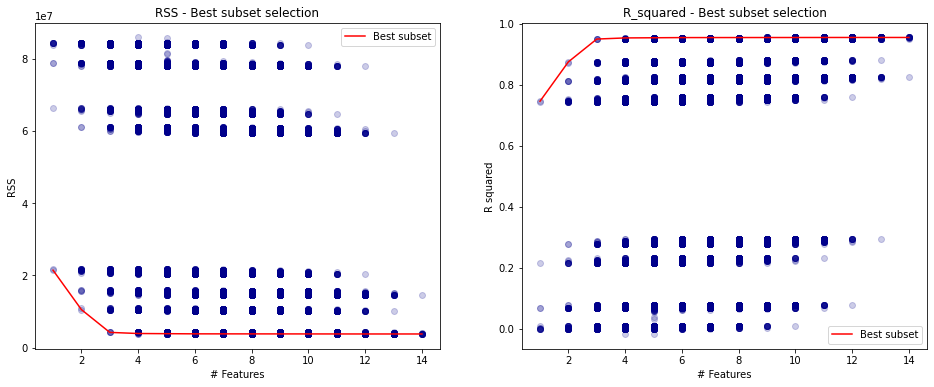

In [17]:
fig = plt.figure(figsize = (16,6))
ax = fig.add_subplot(1, 2, 1)

ax.scatter(df.numb_features,df.RSS, alpha = .2, color = 'darkblue' )
ax.set_xlabel('# Features')
ax.set_ylabel('RSS')
ax.set_title('RSS - Best subset selection')
ax.plot(df.numb_features,df.min_RSS,color = 'r', label = 'Best subset')
ax.legend()

ax = fig.add_subplot(1, 2, 2)
ax.scatter(df.numb_features,df.R_squared, alpha = .2, color = 'darkblue' )
ax.plot(df.numb_features,df.max_R_squared,color = 'r', label = 'Best subset')
ax.set_xlabel('# Features')
ax.set_ylabel('R squared')
ax.set_title('R_squared - Best subset selection')
ax.legend()

plt.show()

RSS가 낮고 R_squared가 높은 지점의 Feature의 갯수는 3개 일때 입니다. 4개 이상부터는 추가적으로 RSS가 감소하거나 결정계수가 증가하지 않으므로 회귀모델을 만드는 데 가장 최적의 Feature 개수는 3개라는 것을 알 수 가 있었습니다.

#### 4.1.2 전진선택법

최상의 부분집합 선택하는 방법은 변수의 모든 경우의 수를 생각해야 하기 때문에 계산이 오래걸립니다. 하지만 전진선택법의 경우에는 아무것도 없는 영모델에서 시작하여 RSS가 적고 결정계수가 높은 모델이 되는 방향으로 변수를 하나씩 추가하는 방식입니다. 

전진선택법으로 이미 선택이 되어진 변수들은 제거되지 않고 끝까지 남게됩니다.

In [18]:
#Initialization variables
k = 11

remaining_features = list(X.columns.values)
features = []
RSS_list, R_squared_list = [np.inf], [np.inf] #Due to 1 indexing of the loop...
features_list = dict()

for i in range(1,k+1):
    best_RSS = np.inf
    
    for combo in itertools.combinations(remaining_features,1):

            RSS = linear_regression(X[list(combo) + features],Y)   #Store temp result 

            if RSS[0] < best_RSS:
                best_RSS = RSS[0]
                best_R_squared = RSS[1] 
                best_feature = combo[0]

    #Updating variables for next loop
    features.append(best_feature)
    remaining_features.remove(best_feature)
    
    #Saving values for plotting
    RSS_list.append(best_RSS)
    R_squared_list.append(best_R_squared)
    features_list[i] = features.copy()

In [19]:
print('Forward stepwise subset selection')
print('Number of features |', 'Features |', 'RSS')
display([(i,features_list[i], round(RSS_list[i])) for i in range(1,5)])

Forward stepwise subset selection
Number of features | Features | RSS


[(1, ['Rating'], 21435122.0),
 (2, ['Rating', 'Income'], 10532541.0),
 (3, ['Rating', 'Income', 'Student_No'], 4227219.0),
 (4, ['Rating', 'Income', 'Student_No', 'Limit'], 4032502.0)]

#### 4.1.3 후진소거법

후진소거법은 전진선택법과 다르게 모든 변수를 가지고 있는 풀모델에서 시작하여 유용성이 가장 적은 설명변수를 제외해 나가는 방식의 변수선택법입니다. 후진소거법은 데이터의 수가 설명변수의 수보다 커야 사용이 가능합니다.

후진소거법은 이미 제거되어진 변수는 다시 포함될 수 없습니다.

In [72]:
a = list(X.columns.values)
b = a.copy()
bucket_RSS = []
bucket_f
while len(b) > 0:
    RSS, R_squared = linear_regression(X[b],Y)
    bucket_RSS.append(RSS)
    feature = b.pop()
    

In [109]:
b = a.copy()
aa = itertools.combinations(b,1)
list(aa)

[('Income',),
 ('Limit',),
 ('Rating',),
 ('Cards',),
 ('Age',),
 ('Education',),
 ('Gender_ Male',),
 ('Gender_Female',),
 ('Student_No',),
 ('Student_Yes',),
 ('Married_No',),
 ('Married_Yes',),
 ('Ethnicity_African American',),
 ('Ethnicity_Asian',),
 ('Ethnicity_Caucasian',)]

In [73]:
a = list(X.columns.values)
b = a.copy()

for combo in itertools.combinations(b,1):

        RSS = linear_regression(X[b.remove(combo)],Y)   #Store temp result 

        if RSS[0] < best_RSS:
            best_RSS = RSS[0]
            best_R_squared = RSS[1] 
            best_feature = combo[0]


[3786730.1906777835,
 3786730.1906777853,
 3789708.9333172943,
 3800814.2375884634,
 3800814.2375884666,
 3805359.4579183124,
 3805359.4579183133,
 10267337.650076622,
 10267337.650076624,
 10268781.247300817,
 10284218.322302196,
 10374439.049277846,
 10437996.423767732,
 10870832.12499005,
 66208744.51078422]

#### 4.1.3 변수선택 척도 : AIC, BIC, $C_p$, adj.$R^2$

AIC, BIC, $C_p$
- AIC, BIC, $C_p$는 변수선택의 척도로 사용되며 크기가 작을수록 좋은 모델이라고 보기에 AIC와 BIC가 보다 더 작은 수치를 가지는 모델을 선택합니다.

$adj.R^2$
- $R^2 = {SSR \over SST}$, SSR은 회귀변동을 의미하며 독립변수가 증가함에 따라서 같이 증가하게 됩니다. 

- 수정된 결정계수는 실제로 종속변수에 영향을 주는 독립변수들의 설명력을 의미하게 됩니다.

In [32]:
df1 = pd.concat([pd.DataFrame({'features':features_list}),pd.DataFrame({'RSS':RSS_list, 'R_squared': R_squared_list})], axis=1, join='inner')
df1['numb_features'] = df1.index

In [33]:
#Initializing useful variables
m = len(Y)
p = 11
hat_sigma_squared = (1/(m - p -1)) * min(df1['RSS'])

#Computing
df1['C_p'] = (1/m) * (df1['RSS'] + 2 * df1['numb_features'] * hat_sigma_squared )
df1['AIC'] = (1/(m*hat_sigma_squared)) * (df1['RSS'] + 2 * df1['numb_features'] * hat_sigma_squared )
df1['BIC'] = (1/(m*hat_sigma_squared)) * (df1['RSS'] +  np.log(m) * df1['numb_features'] * hat_sigma_squared )
df1['R_squared_adj'] = 1 - ( (1 - df1['R_squared'])*(m-1)/(m-df1['numb_features'] -1))
df1

,features,RSS,R_squared,numb_features,C_p,AIC,BIC,R_squared_adj
1,[Rating],2.143512e+07,0.745848,1,53636.603151,5.495771,5.505750,0.745210
2,"[Rating, Income]",1.053254e+07,0.875118,2,26428.949364,2.707991,2.727949,0.874489
3,"[Rating, Income, Student_No]",4.227219e+06,0.949879,3,10714.442485,1.097835,1.127771,0.949499
4,"[Rating, Income, Student_No, Limit]",4.032502e+06,0.952188,4,10276.446437,1.052956,1.092871,0.951703
5,"[Rating, Income, Student_No, Limit, Cards]",3.866091e+06,0.954161,5,9909.218362,1.015329,1.065222,0.953579
6,"[Rating, Income, Student_No, Limit, Cards, Age]",3.821620e+06,0.954688,6,9846.837591,1.008937,1.068809,0.953996
7,"[Rating, Income, Student_No, Limit, Cards, Age...",3.810759e+06,0.954817,7,9868.483418,1.011155,1.081006,0.954010
8,"[Rating, Income, Student_No, Limit, Cards, Age...",3.800969e+06,0.954933,8,9892.806387,1.013647,1.093477,0.954011
9,"[Rating, Income, Student_No, Limit, Cards, Age...",3.794145e+06,0.955014,9,9924.544529,1.016899,1.106707,0.953976
10,"[Rating, Income, Student_No, Limit, Cards, Age...",3.789709e+06,0.955066,10,9962.253028,1.020763,1.120550,0.953911


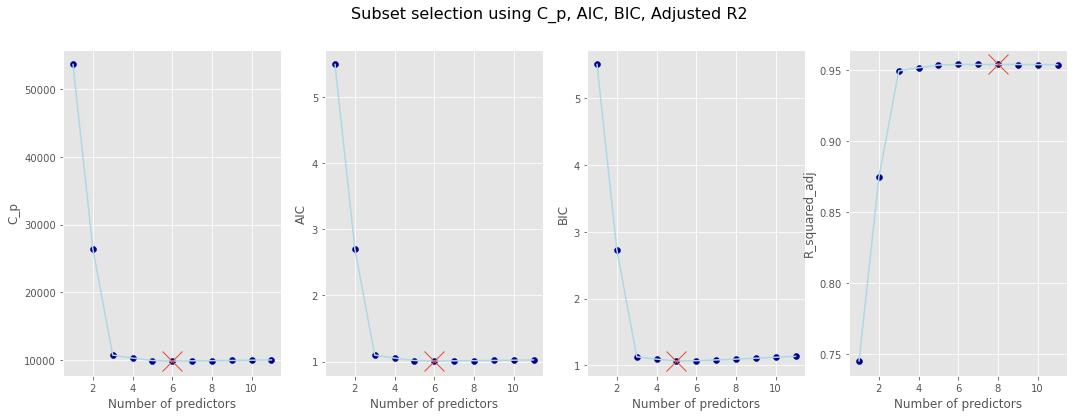

In [34]:
variables = ['C_p', 'AIC','BIC','R_squared_adj']
fig = plt.figure(figsize = (18,6))

for i,v in enumerate(variables):
    ax = fig.add_subplot(1, 4, i+1)
    ax.plot(df1['numb_features'],df1[v], color = 'lightblue')
    ax.scatter(df1['numb_features'],df1[v], color = 'darkblue')
    if v == 'R_squared_adj':
        ax.plot(df1[v].idxmax(),df1[v].max(), marker = 'x', markersize = 20)
    else:
        ax.plot(df1[v].idxmin(),df1[v].min(), marker = 'x', markersize = 20)
    ax.set_xlabel('Number of predictors')
    ax.set_ylabel(v)

fig.suptitle('Subset selection using C_p, AIC, BIC, Adjusted R2', fontsize = 16)
plt.tight_layout()
plt.show()

최적의 subset을 고르기 위한 척도로 사용되는 $C_p$, AIC, BIC, R_squared_adj 값들을 변수의 개수에 따라서 비교해본 결과 빨간색 X자로 표시가 되어있는 부분이 최적의 subset 개수라고 볼 수 있습니다.

### 4.2 Ridge(능형회귀) 와 Lasso

앞에서는 변수선택법을 사용하여 모델의 성능을 비교하였습니다. 모델 성능을 비교하기 위한 척도로써 $BIC$,$AIC$,$C_p$,$adj.R^2$들을 사용하여 실습하는 과정을 하였습니다. 이번에는 모든 특성을 고려하되 기본 모델에 패널티항을 추가하여 계수의 추정치를 수축시키며 기존의 최상의 부분집합 셋을 구하는 방법보다 연산의 이득을 크게 얻을 수 있는 방법을 알아보겠습니다. 

#### 4.2.1 Ridge regression

Ridege regression은 능형회귀라고도 불리며 일반 선형모델에 일반화 항을 추가한 형태의 모델입니다. 식은 아래와 같습니다.
$$argmin_{\beta}{\sum^n_{i=1}(y_i - \beta_0 - \sum^p_{j=1}\beta_jx_{ij})^2 + \lambda\sum^p_{j=1}\beta_j^2}= RSS + \lambda\sum^p_{j=1}\beta_j^2$$ 
해당 식의 파라미터는 $\lambda$로 $\lambda$가 0보다 크거나 같은 값을 가집니다. 만약 $\lambda$가 0인 경우에는 일반 OLS를 사용한 회귀모델과 다를바가 없지만 파라미터인 $\lambda$가 $\inf$로 발산하는 경우 $\beta^2$는 0 에 수렴하게 됩니다. 정리하면 $\lambda$가 커지게 되면 계수 추정치인 $\beta^2$가 수축하게 되어 모델의 유연성이 감소하게 됩니다. 모델의 유연성이 감소하지만 예측값의 variance(분산)이 감소하고 bias(편향)이 증가하게 됩니다. 

Ridge regression의 파라미터에 다양한 수치를 넣은 다음 계수 추정치를 비교하기 위하여 아래와 같은 함수를 만들겠습니다.

In [129]:
def ridge_linear_regression(X,Y,parameter):
    model = Ridge(alpha=parameter)
    model.fit(X,Y)
    RSS = mean_squared_error(Y,model.predict(X)) * len(Y)
    R_squared = model.score(X,Y)
    coeffients = model.coef_
    return RSS, R_squared, np.array(coeffients)

파라미터인 $\lambda$의 수치에 따른 계수의 추정치를 비교하여 보겠습니다.

In [130]:
parameters = np.arange(0,2,0.75)
bucket_RSS = []
bucket_R_squared = []
bucket_coeffients = []
for parameter in parameters:
    RSS, R_squared, coeffients = ridge_linear_regression(X, Y, parameter)
    bucket_RSS.append(RSS)
    bucket_R_squared.append(R_squared)
    bucket_coeffients.append(coeffients)
bucket_coeffients = np.array(bucket_coeffients)
df3 = pd.DataFrame({"RSS":bucket_RSS,"R_squared":bucket_R_squared})
df3.head()

,RSS,R_squared
0,3.838728e+06,0.954485
1,3.787446e+06,0.955093
2,3.789534e+06,0.955068


조율파라미터인 $\lambda$의 수치가 커짐에 따라서 계수 추정치가 0에 가까워 진다는 것을 알 수 있습니다.

In [132]:
bucket_coeffients[:,1]

array([0.15355988, 0.18998457, 0.1890823 ])

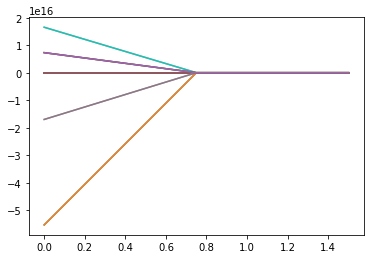

In [94]:
for i in range(15):
    plt.plot(parameters, bucket_coeffients[:,i])
plt.show()

계수 추정치가 0에 수렴하는 구간에서 RSS는 최소값을 지니고 이후로 조율파라미터가 증가할수록 조금씩 RSS가 증가하는 형태입니다.

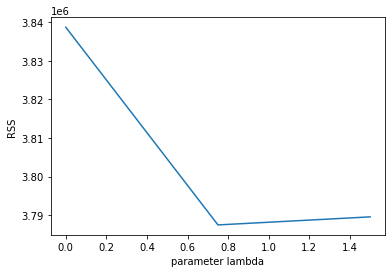

In [213]:
plt.plot(parameters, df3["RSS"])
plt.xlabel("parameter lambda")
plt.ylabel("RSS")
plt.show()

계수 추정치가 0에 수렴하는 구간에서 결정계수는 최대값을 지니고 이후로 조율파라미터가 증가할수록 조금씩 결정계수가 감소하는 추세입니다.

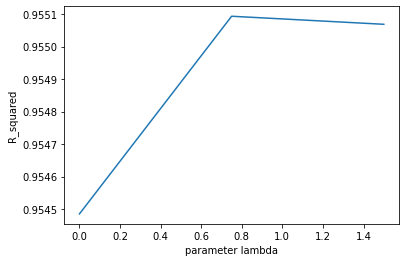

In [214]:
plt.plot(parameters, df3["R_squared"])
plt.xlabel("parameter lambda")
plt.ylabel("R_squared")
plt.show()

#### 4.2.2 Lasso regression

Lasso regression은 Ridge 모델의 일반화 항에 절대값을 추가한 형태의 모델입니다. 식은 아래와 같습니다.
$$argmin_{\beta}{\sum^n_{i=1}(y_i - \beta_0 - \sum^p_{j=1}\beta_jx_{ij})^2 + \lambda\sum^p_{j=1}|\beta|}= RSS + \lambda\sum^p_{j=1}|\beta|$$ 

lasso 또한 ridge와 같이 계수 추정치들을 0으로 수축시킵니다. 하지만 lasso에서 $L_1$페널티는 $\lambda$가 충분히 클 경우 계수 추정치들의 일부를 정확히 0이 되게 하는 효과를 가졌습니다. 따라서, 최상의 부분집합 선택 처럼 lasso는 변수 선택 기능을 수행할 수 있습니다. 그 결과 lasso로부터 생성된 모델은 ridge 회귀에 의해 생성된것보다 일반적으로 해석하기가 더 쉽습니다.

lasso regression의 파라미터에 다양한 수치를 넣은 다음 계수 추정치를 비교하기 위하여 아래와 같은 함수를 만들겠습니다.

In [175]:
def lasso_linear_regression(X,Y,parameter):
    model = Lasso(alpha=parameter)
    model.fit(X,Y)
    RSS = mean_squared_error(Y,model.predict(X)) * len(Y)
    R_squared = model.score(X,Y)
    coeffients = model.coef_
    return RSS, R_squared, np.array(coeffients)

In [176]:
parameters = np.arange(0,100,1)
bucket_RSS = []
bucket_R_squared = []
bucket_coeffients = []
for parameter in parameters:
    RSS, R_squared, coeffients = lasso_linear_regression(X.iloc[:,:6],Y,parameter)
    bucket_RSS.append(RSS)
    bucket_R_squared.append(R_squared)
    bucket_coeffients.append(coeffients)
bucket_coeffients = np.array(bucket_coeffients)
df4 = pd.DataFrame({"RSS":bucket_RSS,"R_squared":bucket_R_squared})

계수 추정치를 비교하기 위하여 표준화를 하였습니다.

In [177]:
bucket_coeffients = (bucket_coeffients - np.mean(bucket_coeffients)) / np.std(bucket_coeffients)

조율파라미터인  𝜆 의 수치가 커짐에 따라서 계수 추정치가 0에 가까워 진다는 것을 알 수 있습니다. 또한 lasso 의 특성상 𝜆가 충분히 클 경 우 계수 추정치들의 일부를 정확히 0이 되게 하는 효과가 있습니다. 현재 데이터의 경우에는 Age변수의 계수 추정치가 0이되어 모델에 주는 영향이 없다는 것을 알 수가 있습니다.

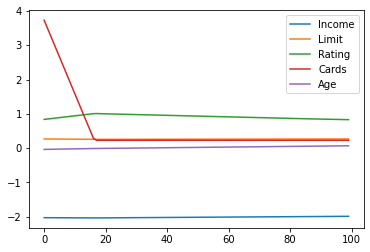

In [178]:
for i in range(5):
    plt.plot(parameters, bucket_coeffients[:,i], label = X.iloc[:,:6].columns[i])
    plt.legend()
plt.show()

Text(0, 0.5, 'RSS')

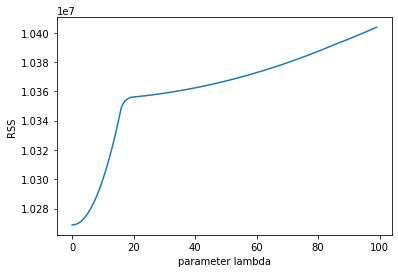

In [179]:
fig, axes = plt.subplots()
df4["RSS"].plot()
plt.xlabel("parameter lambda")
plt.ylabel("RSS")

Text(0, 0.5, 'R_squared')

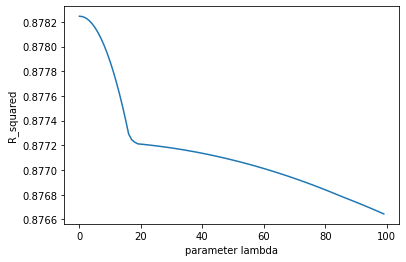

In [180]:
df4["R_squared"].plot()
plt.xlabel("parameter lambda")
plt.ylabel("R_squared")

#### 4.2.3 lasso와 ridge 비교
일반적으로 lasso는 비교적 적은 수의 설명변수가 상당히 큰 계수를 가지고 나머지 변수들은 계수가 아주 작거나 0인 설정에서 성능이 더 나을 것이라고 기대할 수 있습니다. lasso는 최소제곱 추정치가 아주 높은 분산을 가질 때 약간의 편향 증가로 분산을 크게 줄여주어 결과적으로 더 정확한 예측이 가능해지도록 해줍니다. 또한 lasso는 ridge와 달리 변수선택을 수행하기에 모델의 해석력이 더 높은 모델을 얻을 수가 있습니다. ridge는 반응변수가 많은 설명변수들의 함수이고 그 계수들이 거의 동일한 크기일 때 성능이 더 좋습니다.

### 4.3 차원 축소 방법

앞에서 독립변수간의 다중공선성이 존재하는 것을 보고 이를 줄이기 위한 노력으로 일부 독립변수를 제거하는 방식을 사용하였습니다. 하지만 차원 축소 방법은 N개의 독립변수 차원을 N개보다 적은 수의 차원으로 축소하는 방식입니다.

- 대표적인 방법으로는 주성분 분석(PCA)가 존재하며 해당 방식은 차원이 축소된 만큼 일부 분산의 소실이 생기지만 이는 사용자 마음대로 주성분의 개수를 조절하여 데이터가 소실되는 정도를 조절할 수 있습니다. 


- 차원을 축소함으로써 계산해야하는 차원 수가 줄기 때문에 연산상의 이득을 얻을 수 있으며 다차원의 데이터를 2차원이나 3차원으로 줄여서 시각화 또한 가능하게 됩니다. 

- 데이터의 수보다 데이터의 변수의 개수가 더 많은 경우 변수의 개수를 차원축소함으로써 분석이 가능한 형태로 만들어 집니다.


- 주성분 분석을 데이터에 적용한 뒤 회귀모델을 만드는 방식이 주성분 회귀(PCR)이며 반응변수(Y)와 관련이 있는 주성분으로 회귀모델을 만든 것이 부분최소제곱 회귀 입니다.

#### 4.3.1 주성분 회귀

주성분 분석을 실시할때 적용되는 데이터는 양적 변수이어야 합니다. 만약 질적 변수가 포함되어 있을 경우 공분산 행렬을 만들기가 어렵기 때문에 기존의 주성분 분석이 아닌 다른 분석을 진행해야 합니다. 

그러므로 변수중에서 질적변수인 부분은 제거한 뒤 주성분 회귀모델을 만들어 보겠습니다.

In [165]:
part_X = X.iloc[:,:6]
part_X.shape

(400, 6)

주성분 분석을 할 시 각 설명변수에 표준화를 하는 것이 일반적으로 권장됩니다. 왜냐하면 이러한 표준화를 거친 변수들은 동일한 범위를 가지게 되어 모델이 분석하기에 더 용이하기 때문입니다.

In [167]:
part_X = (part_X - np.mean(part_X)) / np.std(part_X)
part_X

,Income,Limit,Rating,Cards,Age,Education
1,-0.861583,-0.489999,-0.465539,-0.699130,-1.257674,-0.784930
2,1.727437,0.828261,0.828703,0.031032,1.528451,0.496588
3,1.686756,1.014787,1.029311,0.761194,0.889964,-0.784930
4,2.946152,2.068440,2.110003,0.031032,-1.141586,-0.784930
5,0.302928,0.070012,0.013331,-0.699130,0.715831,0.816968
...,...,...,...,...,...,...
396,-0.940986,-0.275711,-0.310230,0.031032,-1.373763,-0.144171
397,-0.904963,-0.389362,-0.381413,1.491355,0.541698,1.137347
398,0.359462,-0.244913,-0.219633,1.491355,0.657787,-0.464550
399,-0.212808,-0.958916,-1.054419,-1.429291,-0.677231,-0.144171


주성분 회귀란 주성분 분석으로 나온 주성분으로 회귀모델을 만드는 방법으로 파이썬에서는 sklearn 패키지를 통하여 PCA 함수를 사용하면 쉽게 구현이 가능합니다.

In [168]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca_X = pca.fit_transform(part_X)
pca_X.shape

(400, 2)

주성분의 개수를 다르게 하여 회귀모델에 적합한 결과 아래와 같이 나왔습니다. 

1개의 주성분으로 설명가능한 분산은 약 45.87878% 입니다
단순회귀모델의 RSS : 35191805.43526091, R_Squared : 0.582738413660967


2개의 주성분으로 설명가능한 분산은 약 63.48407% 입니다
단순회귀모델의 RSS : 35185825.54286635, R_Squared : 0.5828093159450591


3개의 주성분으로 설명가능한 분산은 약 80.06588% 입니다
단순회귀모델의 RSS : 34112514.85058313, R_Squared : 0.595535327485462


4개의 주성분으로 설명가능한 분산은 약 95.56949% 입니다
단순회귀모델의 RSS : 31645199.427679654, R_Squared : 0.6247897500598699


5개의 주성분으로 설명가능한 분산은 약 99.96365% 입니다
단순회귀모델의 RSS : 10269173.776270978, R_Squared : 0.8782406390555717




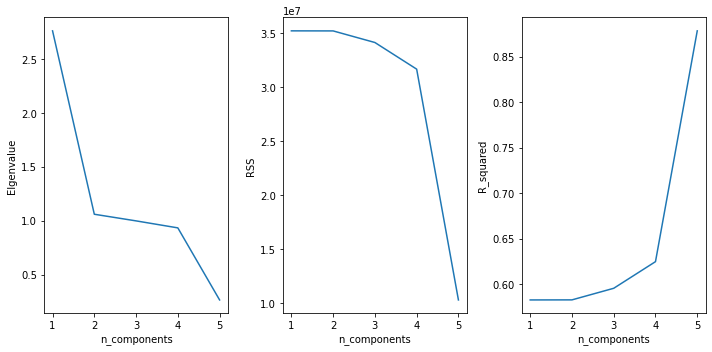

In [169]:
bucket_RSS = []
bucket_R_squared = []
for i in range(1,6):
    pca = PCA(n_components=i)
    pca_X = pca.fit_transform(part_X)

    sum_ratio = round(sum(pca.explained_variance_ratio_) * 100, 5)
    len_ratio = len(pca.explained_variance_ratio_)
    print("{}개의 주성분으로 설명가능한 분산은 약 {}% 입니다".format(len_ratio, sum_ratio))
    RSS, R_squared = linear_regression(pca_X, Y)
    print("단순회귀모델의 RSS : {}, R_Squared : {}".format(RSS, R_squared))
    
    bucket_RSS.append(RSS)
    bucket_R_squared.append(R_squared)
    print("\n")

fig, ax = plt.subplots(1,3,figsize=(10,5))

ax[0].plot(range(1,6), pca.explained_variance_)
ax[0].set_xlabel("n_components")
ax[0].set_ylabel("EIgenvalue")

ax[1].plot(range(1,6), bucket_RSS)
ax[1].set_xlabel("n_components")
ax[1].set_ylabel("RSS")

ax[2].plot(range(1,6), bucket_R_squared)
ax[2].set_xlabel("n_components")
ax[2].set_ylabel("R_squared")
plt.tight_layout()
plt.show()

보통 주성분의 개수를 정하는 기준은 Eigenvalue가 급격히 감소하는 구간의 n_components를 사용하며 해당 데이터의 경우에는 2개의 주성분을 사용할때와 4개의 주성분을 사용하는 것이 좋습니다. 데이터를 시각화 하기위한 차원축소의 경우 제2 주성분까지만 사용하면 되고 모델을 만들어야 할시 되도록 설명가능한 분산이 크고 Eigenvalue가 급격히 떨어진느 구간을 선택해야 하므로 제 4 주성분까지 사용하는 것이 좋습니다.

#### 4.3.1 부분최소제곱 회귀

In [142]:
def partial_linear_regression(X,Y,n_components):
    model = PLSRegression(n_components=n_components)
    model.fit(X,Y)
    RSS = mean_squared_error(Y,model.predict(X)) * len(Y)
    R_squared = model.score(X,Y)
    return RSS, R_squared

In [143]:
part_X = (part_X - np.mean(part_X)) / np.std(part_X)

,Income,Limit,Rating,Cards,Age,Education
1,-0.861583,-0.489999,-0.465539,-0.699130,-1.257674,-0.784930
2,1.727437,0.828261,0.828703,0.031032,1.528451,0.496588
3,1.686756,1.014787,1.029311,0.761194,0.889964,-0.784930
4,2.946152,2.068440,2.110003,0.031032,-1.141586,-0.784930
5,0.302928,0.070012,0.013331,-0.699130,0.715831,0.816968
...,...,...,...,...,...,...
396,-0.940986,-0.275711,-0.310230,0.031032,-1.373763,-0.144171
397,-0.904963,-0.389362,-0.381413,1.491355,0.541698,1.137347
398,0.359462,-0.244913,-0.219633,1.491355,0.657787,-0.464550
399,-0.212808,-0.958916,-1.054419,-1.429291,-0.677231,-0.144171


In [144]:
parameters = np.arange(1,5)
bucket_RSS = []
bucket_R_squared = []
for parameter in parameters:
    RSS, R_squared = partial_linear_regression(X,Y,parameter)
    bucket_RSS.append(RSS)
    bucket_R_squared.append(R_squared)
df4 = pd.DataFrame({"RSS":bucket_RSS,"R_squared":bucket_R_squared})
df4